In [177]:
import torch
import torch.nn as nn
from torch.nn import functional as fn
from torch.autograd import Variable
import matplotlib
import torch.nn.functional as F 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys

In [178]:
import plotly 
plotly.tools.set_credentials_file(username='mishra40', api_key='nuOxcWWzZSBv7dFtO4F3')
import plotly.plotly as py
import plotly.graph_objs as go

In [179]:
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 18:21:58) 
[GCC 7.2.0]
__pyTorch VERSION: 0.4.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2015 NVIDIA Corporation
Built on Tue_Aug_11_14:27:32_CDT_2015
Cuda compilation tools, release 7.5, V7.5.17
__CUDNN VERSION: 7102
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [180]:
test_xyz = []

with open('test/8v/data.pickle', 'rb') as f:
    data = pickle.load(f)

for i in range(len(data)):
    obj = np.asarray(data[i])
    #print("obj: ", obj)
    nv = 8
    dim = 36
    #print(obj.shape)
    test_xyz.append((obj))
    #print(train_xyz)
test_xyz = torch.Tensor(test_xyz)
test_xyz.shape  

torch.Size([1000, 3, 36])

In [149]:
train_xy = []

with open('training/8v/data.pickle', 'rb') as f:
    data = pickle.load(f)
    
for i in range(len(data)):
    obj = np.asarray(data[i])
    obj[2,0:8]=np.random.rand(8)
    train_xy.append(obj)
    #print(train_xyz)
train_xy = torch.Tensor(train_xy)
train_xy.shape        

torch.Size([10000, 3, 36])

In [167]:
def expand_conn_mat(nverts, vverts, conn_mat):
    conn_mat=conn
    new_conn_mat = torch.Tensor()
    tot = (vverts*(vverts-1))/2
    nv_seq = np.arange(nverts)[::-1]
    vv_seq = np.arange(vverts)[::-1]
    # convert vverts conn_mat to nverts conn_mat
    for i,v in enumerate(vv_seq):
            if (v==0):
                break
            pad = min(nverts-vverts, nverts-i-1)
            n1 = max(vverts-i-1,0)
            n2 = tot - n1
            #print("i,pad,n1,n2,tot,conn_mat -- ",i,pad,n1,n2,tot,conn_mat)
            if (tot > 1): 
                c1,c2 = torch.Tensor.split(conn_mat,[n1,n2],dim=2)
            else:
                c1 = conn_mat #torch.Tensor.clone(conn_mat)
                c2 = torch.Tensor(conn_mat) #torch.Tensor.zero_(conn_mat)
            if (tot==0):
                pad = pad-1
            m = nn.ZeroPad2d((0,pad,0,0))
            c1 = m(c1)
            new_conn_mat = torch.cat((new_conn_mat,c1), dim=2)
            #print("new_conn_mat -- ",new_conn_mat)
            conn_mat = c2
            tot = c2.size()[-1]
    # number of elements to skip from vverts        
    n = vv_seq[0]        
    # create rest of vverts conn_mat
    for i,v in enumerate(nv_seq[n:]):
        if (v==0):
            break  
        c1 = torch.zeros(1,3,v)
        new_conn_mat = torch.cat((new_conn_mat,c1), dim=2)
    return new_conn_mat

In [168]:
# new version
import torch.nn.functional as F 
from functools import reduce

def num_edges(n):
    return int(n*(n-1)/2)

class DepthEstNet(nn.Module):    
    def __init__(self, vertices, nonlinearity = fn.tanh, additional_hidden_wide=0):
        super(DepthEstNet, self).__init__()
        self.vertices = vertices
        input_dim = vertices * 3
        self.edges = int(num_edges(vertices))
        edge_dim = self.edges * 3
        edges = self.edges
        self.conv_edge_vec = nn.ModuleList()
        self.conv_edge_num = vertices-1
        
        self.fc0 = nn.Linear(vertices, vertices)
        #self.conv_edge_vec.append(fc0)
        #torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)

        for i in range(1,vertices):
            m = nn.Conv1d(3, 3, 2, stride=1, dilation=i)
            m.weight = torch.nn.Parameter(torch.from_numpy(np.array(
            [[[1, -1],
             [0, 0],
             [0, 0]],
    
            [[0, 0],
             [1,-1],
             [0,0]],

            [[0,  0],
             [0, 0],
             [1, -1]]], dtype=np.float32)))
            m.bias = torch.nn.Parameter(torch.from_numpy(np.array([0,0,0], dtype=np.float32)))
            m.requires_grad = False
            self.conv_edge_vec.append(m)
        
            #torch.nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, 
            #groups=1, bias=True, dilation=1)
        
        self.deconv_edge_vec = nn.ModuleList()
        self.deconv_edge_num = vertices-1
        for i in range(1,vertices):
            m = nn.Conv1d(3, 3, 2, stride=1, dilation=vertices-i)
            m.requires_grad = True
            self.deconv_edge_vec.append(m)        
        
        
        self.reverse_learn_params = nn.ModuleList()
        fc1 = nn.Linear(edges, edges*10)
        self.reverse_learn_params.append(fc1)
        fc2 = nn.Linear(edges*10, edges*20)
        self.reverse_learn_params.append(fc2)
        fc3 = nn.Linear(edges*20, vertices*20)
        self.reverse_learn_params.append(fc3)        
        fc4 = nn.Linear(vertices*20, vertices*10)
        self.reverse_learn_params.append(fc4)
        fc5 = nn.Linear(vertices*10, vertices)
        self.reverse_learn_params.append(fc5)
        
        self.layernorm = nn.LayerNorm(edges)
        self.nonlinearity = nonlinearity
        self.cos = nn.CosineSimilarity(dim=0, eps=1e-6)


    def forward(self, vverts, conn_mat, extract_x=False, extract_y=False, extract_z=False):
        #print("initial x", x)
        n,d,vv = vverts.size()
        #print(n,d,v)
    
        #padding for missing verts
        nverts = self.vertices
        pad = nverts - vv
        m = nn.ZeroPad2d((0, pad, 0, 0)) #padding(left,right,top,bottom)
        x = m(vverts)
        
        n,d,num_v_edge = conn_mat.size()
        #conn_mat = expand_conn_mat(nverts,vv,conn_mat)
        
        for i in range(self.conv_edge_num):
            y = self.conv_edge_vec[i](x)
            y = self.nonlinearity(y)
            if (i==0):
                output = y
            else:
                output = torch.cat((output,y), dim=2)
    
                    
        x_vec =  output[:,0,:] 

        temp = (self.reverse_learn_params[0](x_vec))
        temp = (self.reverse_learn_params[1](temp))
        temp = (self.reverse_learn_params[2](temp))
        temp = (self.reverse_learn_params[3](temp))
        vertexs_recovered = (self.reverse_learn_params[4](temp))
        optimizer = torch.optim.SGD(self.reverse_learn_params.parameters(), lr = 1e-1 , momentum=0.8)
        criterion = nn.MSELoss()
        optimizer.zero_grad()
        #print(" vertexs_recovered:", vertexs_recovered)
        #print(" x[:,0,:]:", x[:,0,:])
        loss = criterion(vertexs_recovered, x[:,0,:])
        #print("loss", loss)
        loss.backward(retain_graph=True)
        optimizer.step()
          
        y=output
        output = output*conn_mat
        
        if (extract_x):
            vec = output[:,0,:] #y[i,0,:]
            print("x output vec:", vec)
            temp = (self.reverse_learn_params[0](vec))
            temp = (self.reverse_learn_params[1](temp))
            temp = (self.reverse_learn_params[2](temp))
            temp = (self.reverse_learn_params[3](temp))
            vertexs_recovered = (self.reverse_learn_params[4](temp))
            return vertexs_recovered        
        
        if (extract_y):
            vec = output[:,1,:] #y[i,0,:]
            print("y output vec:", vec)
            temp = (self.reverse_learn_params[0](vec))
            temp = (self.reverse_learn_params[1](temp))
            temp = (self.reverse_learn_params[2](temp))
            temp = (self.reverse_learn_params[3](temp))
            vertexs_recovered = (self.reverse_learn_params[4](temp))
            return vertexs_recovered          
            
        if (extract_z):
            vec = output[:,2,:] #y[i,0,:]
            print("z output vec:", vec)
            temp = (self.reverse_learn_params[0](vec))
            temp = (self.reverse_learn_params[1](temp))
            temp = (self.reverse_learn_params[2](temp))
            temp = (self.reverse_learn_params[3](temp))
            vertexs_recovered = (self.reverse_learn_params[4](temp))
            return vertexs_recovered  
        
                
        #print("output: ",output)
        n,d,e = output.size()            
        output = F.normalize(output, p=2, dim=1)
        #print("normalized output",output)
        #pool all dimensions for Gram Matrix
        n,d,e = output.size()
        output = [torch.mm(mat.transpose(1,0),mat) for mat in output[:]]
        #print(type(output))
        return torch.stack(output)

In [169]:
nverts = 20
model = DepthEstNet(nverts, nonlinearity=fn.sigmoid, additional_hidden_wide=1)
criterion = nn.MSELoss()

In [170]:
train_xy_obj = [] #torch.Tensor()
train_xy_conn = []
objs = []

with open('training/vverts/cube/data.pickle', 'rb') as f:
    data = pickle.load(f)

for i in range(len(data)):
    if(i%2 > 0):
        continue
    obj = np.asarray(data[i])
    print("obj: ", obj)
    print("obj shape: ", obj.shape)
    objs.append(np.copy(obj))
    
    vv = obj.shape[1]
    obj[2,0:vv]=0
    vverts = torch.from_numpy(np.asarray(obj,dtype=np.float32))
    vverts = vverts.unsqueeze(0)
    pad = nverts - vv
    m = nn.ZeroPad2d((0, pad, 0, 0)) #padding(left,right,top,bottom)
    x = m(vverts)
    train_xy_obj.append(x)    
    
    conn = np.asarray(data[i+1]) 
    conn = torch.from_numpy(np.asarray(conn,dtype=np.float32))
    conn = conn.unsqueeze(0)
    #print("conn: ", conn)
    #print("conn shape: ", conn.shape)
    conn_mat = expand_conn_mat(nverts,vv,conn)
    #print("conn mat: ", conn_mat)    
    train_xy_conn.append(conn_mat)


train_xy_obj = torch.cat(train_xy_obj)
print(train_xy_obj.shape)

train_xy_conn = torch.cat(train_xy_conn)
print(train_xy_conn.shape)

obj:  [[ 0.67700416  0.67219573  0.65319693  0.7161352  -0.65109855 -0.67953897]
 [ 0.59628034 -0.60950673  0.6123395  -0.59657985 -0.63365114 -0.60201341]
 [-0.31490099 -0.34420356  0.30247796  0.33627811 -0.32576427  0.31978053]]
obj shape:  (3, 6)
obj:  [[ 0.55752116  0.55356139  0.53791565  0.58974606 -0.53618759 -0.55960864]
 [ 0.38592494 -0.39448494  0.39631835 -0.38611883 -0.41011173 -0.38963553]
 [-0.25861984 -0.28268448  0.24841641  0.27617627 -0.26754078  0.26262727]]
obj shape:  (3, 6)
obj:  [[ 0.39248163  0.38969404  0.37867978  0.41516718 -0.37746328 -0.38222879
  -0.39395115]
 [ 0.51416165 -0.52556205  0.52800488 -0.51442009 -0.54638135  0.54952991
  -0.5191052 ]
 [-0.85913873 -0.93907583  0.82523715  0.91746116 -0.88876832  0.87581289
   0.87245136]]
obj shape:  (3, 7)
obj:  [[ 0.47159031  0.46824083  0.45500657  0.49884835 -0.45354486 -0.45927092
  -0.47335601]
 [ 0.15162562 -0.15498431  0.15570492 -0.15170191 -0.16112393  0.16205245
  -0.15308346]
 [-0.67874175 -0.7418

obj:  [[ 0.91154951  0.90507519  0.87949431  0.96423727 -0.87666893 -0.88773698
  -0.91496247]
 [ 0.23251718 -0.23766817  0.23877317 -0.23263419 -0.24708325  0.24850713
  -0.23475279]
 [-0.98297238 -1.07442868  0.94418192  1.04970121 -1.01687014  1.0020473
   0.99820393]]
obj shape:  (3, 7)
obj:  [[ 0.54703373  0.5431484   0.52779698  0.57865244 -0.52610147 -0.53274351
  -0.54908192]
 [ 0.94234121 -0.96324098  0.96771789 -0.94281459 -1.00139809  1.00716865
  -0.95140159]
 [-0.85355729 -0.93297845  0.81987911  0.91150093 -0.88299769  0.87012643
   0.86678344]]
obj shape:  (3, 7)
obj:  [[ 0.56072855  0.55674595  0.5410102   0.59313875 -0.53927219 -0.54608059
  -0.562828  ]
 [ 0.87789482 -0.89736456  0.90153533 -0.87833589 -0.93291211  0.93828803
  -0.88633561]
 [-0.88494563 -0.96728665  0.85002828  0.94502008 -0.91546798  0.90212333
   0.89865822]]
obj shape:  (3, 7)
obj:  [[ 0.26112634  0.25927168  0.25194371  0.27621952 -0.25113434 -0.26210403]
 [ 0.29212666 -0.29860687  0.29999465 -0.

obj:  [[ 0.12401274  0.12313194  0.11965176  0.1311807  -0.11926738 -0.12077314
  -0.12447706]
 [ 0.66460657 -0.67935032  0.68250746 -0.6649403  -0.7062614   0.71033114
  -0.67099655]
 [-0.11184992 -0.12226138  0.10744064  0.11944298 -0.11571189  0.11402523
   0.11358309]]
obj shape:  (3, 7)
obj:  [[ 0.0115661   0.01148395  0.01115937  0.01223462 -0.0111159  -0.01112352
  -0.01126395 -0.0116094 ]
 [ 0.85664397 -0.87564731  0.87971687 -0.85707426  0.8943727  -0.91033435
   0.91558009 -0.86488038]
 [-0.2241091  -0.24496651  0.21527098  0.23932289 -0.21705717 -0.23184358
   0.22846408  0.22758178]]
obj shape:  (3, 8)
obj:  [[ 0.87363744  0.86743242  0.84291548  0.9241339  -0.84020758 -0.87690842]
 [ 0.4152644  -0.42447358  0.42644647 -0.41547304 -0.44128838 -0.41925704]
 [-0.47941801 -0.52402568  0.46050116  0.51196325 -0.49595299  0.48684677]]
obj shape:  (3, 6)
obj:  [[ 0.96231472  0.95547986  0.92847437  1.01793671 -0.92549163 -0.96591777]
 [ 0.6658392  -0.68061     0.68377304 -0.66617

obj:  [[ 0.04363085  0.04332096  0.04209654  0.04615272 -0.04193258 -0.04196131
  -0.04249107 -0.04379421]
 [ 0.12344527 -0.12617984  0.12676652 -0.1235074   0.12888196 -0.13117839
   0.13193434 -0.12463217]
 [-0.53701115 -0.58697492  0.51581931  0.57346594 -0.52011377 -0.55552983
   0.54743201  0.54533231]]
obj shape:  (3, 8)
obj:  [[ 0.73419654  0.72898185  0.70837808  0.77663326 -0.70610243 -0.73694545]
 [ 0.21415973 -0.21890971  0.21992713 -0.21426731 -0.22758143 -0.21621883]
 [-0.16508459 -0.18044549  0.1585712   0.17629136 -0.17077884  0.16764264]]
obj shape:  (3, 6)
obj:  [[ 0.16536157  0.16418709  0.15954654  0.1749195  -0.15892512 -0.15903398
  -0.16104181 -0.1659807 ]
 [ 0.31572577 -0.32272464  0.3242248  -0.31588447  0.32963094 -0.33550894
   0.33744234 -0.31876138]
 [-0.73967928 -0.80850059  0.7104907   0.78989226 -0.7164048  -0.76518804
   0.75403404  0.75114089]]
obj shape:  (3, 8)
obj:  [[ 0.1039689   0.10323046  0.10031278  0.10997833 -0.09992208 -0.09999052
  -0.101252

obj:  [[ 0.88831198  0.88200271  0.85707396  0.93965662 -0.85432065 -0.89163792]
 [ 0.5641169  -0.57662934  0.57930934 -0.56440026 -0.59947145 -0.56954074]
 [-0.35920769 -0.39263228  0.34503594  0.38359255 -0.3715986   0.36477381]]
obj shape:  (3, 6)
obj:  [[ 0.57311535  0.56904483  0.55296147  0.60624158 -0.55118507 -0.55814385
  -0.57526118]
 [ 0.16574626 -0.16941816  0.17020583 -0.16582967 -0.17612955  0.17714453
  -0.16733989]
 [-0.68902433 -0.75313157  0.6618337   0.73579854 -0.7127853   0.70239514
   0.69970101]]
obj shape:  (3, 7)
obj:  [[ 0.1850016   0.18368763  0.17849591  0.19569473 -0.1778007  -0.17792249
  -0.18016879 -0.18569428]
 [ 0.87853694 -0.89802051  0.90219432 -0.87897831  0.91722977 -0.93359405
   0.9389739  -0.88698381]
 [-0.94439709 -1.03226924  0.90713352  1.00850725 -0.91468084 -0.97696948
   0.96272832  0.95903087]]
obj shape:  (3, 8)
obj:  [[ 0.89632773  0.88996154  0.86480784  0.94813567 -0.86143953 -0.86202961
  -0.89968371]
 [ 0.23846556 -0.24375503  0.244

In [171]:
import torch.utils.data
dataset = torch.utils.data.TensorDataset(train_xy_obj, train_xy_conn)
loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)

cuda:0
network loss ->  tensor(126.8424, device='cuda:0')
network loss ->  tensor(86.6470, device='cuda:0')
network loss ->  tensor(171.7283, device='cuda:0')
network loss ->  tensor(57.7334, device='cuda:0')
network loss ->  tensor(52.3127, device='cuda:0')
network loss ->  tensor(50.7129, device='cuda:0')
network loss ->  tensor(94.4059, device='cuda:0')
network loss ->  tensor(69.2007, device='cuda:0')
network loss ->  tensor(35.3736, device='cuda:0')
network loss ->  tensor(81.0033, device='cuda:0')
network loss ->  tensor(100.6757, device='cuda:0')
network loss ->  tensor(34.5834, device='cuda:0')
network loss ->  tensor(59.3096, device='cuda:0')
network loss ->  tensor(59.1731, device='cuda:0')
network loss ->  tensor(83.5423, device='cuda:0')
network loss ->  tensor(80.7296, device='cuda:0')
network loss ->  tensor(57.2836, device='cuda:0')
network loss ->  tensor(66.4849, device='cuda:0')
network loss ->  tensor(57.0522, device='cuda:0')
network loss ->  tensor(66.1134, device=

network loss ->  tensor(54.0564, device='cuda:0')
network loss ->  tensor(44.0497, device='cuda:0')
network loss ->  tensor(34.0149, device='cuda:0')
network loss ->  tensor(34.0143, device='cuda:0')
network loss ->  tensor(54.0745, device='cuda:0')
network loss ->  tensor(54.0635, device='cuda:0')
network loss ->  tensor(44.0343, device='cuda:0')
network loss ->  tensor(65.0988, device='cuda:0')
network loss ->  tensor(34.0136, device='cuda:0')
network loss ->  tensor(34.0148, device='cuda:0')
network loss ->  tensor(34.0196, device='cuda:0')
network loss ->  tensor(75.1425, device='cuda:0')
network loss ->  tensor(54.0529, device='cuda:0')
network loss ->  tensor(44.0341, device='cuda:0')
network loss ->  tensor(75.1319, device='cuda:0')
network loss ->  tensor(75.1181, device='cuda:0')
network loss ->  tensor(75.1169, device='cuda:0')
network loss ->  tensor(34.0168, device='cuda:0')
network loss ->  tensor(44.0327, device='cuda:0')
network loss ->  tensor(65.0703, device='cuda:0')


network loss ->  tensor(44.0225, device='cuda:0')
network loss ->  tensor(44.0218, device='cuda:0')
network loss ->  tensor(44.0226, device='cuda:0')
network loss ->  tensor(54.0306, device='cuda:0')
network loss ->  tensor(54.0472, device='cuda:0')
network loss ->  tensor(54.0299, device='cuda:0')
network loss ->  tensor(75.0519, device='cuda:0')
network loss ->  tensor(65.0320, device='cuda:0')
network loss ->  tensor(44.0160, device='cuda:0')
network loss ->  tensor(54.0372, device='cuda:0')
network loss ->  tensor(44.0226, device='cuda:0')
network loss ->  tensor(34.0062, device='cuda:0')
network loss ->  tensor(44.0173, device='cuda:0')
network loss ->  tensor(75.0675, device='cuda:0')
network loss ->  tensor(54.0443, device='cuda:0')
network loss ->  tensor(44.0259, device='cuda:0')
network loss ->  tensor(54.0495, device='cuda:0')
network loss ->  tensor(44.0263, device='cuda:0')
network loss ->  tensor(65.0482, device='cuda:0')
network loss ->  tensor(44.0150, device='cuda:0')


network loss ->  tensor(54.0226, device='cuda:0')
network loss ->  tensor(44.0109, device='cuda:0')
network loss ->  tensor(65.0302, device='cuda:0')
network loss ->  tensor(44.0121, device='cuda:0')
network loss ->  tensor(75.0447, device='cuda:0')
network loss ->  tensor(75.0374, device='cuda:0')
network loss ->  tensor(54.0183, device='cuda:0')
network loss ->  tensor(44.0126, device='cuda:0')
network loss ->  tensor(54.0300, device='cuda:0')
network loss ->  tensor(75.0455, device='cuda:0')
network loss ->  tensor(54.0241, device='cuda:0')
network loss ->  tensor(44.0122, device='cuda:0')
network loss ->  tensor(44.0150, device='cuda:0')
network loss ->  tensor(44.0214, device='cuda:0')
network loss ->  tensor(54.0255, device='cuda:0')
network loss ->  tensor(75.0451, device='cuda:0')
network loss ->  tensor(54.0256, device='cuda:0')
network loss ->  tensor(54.0215, device='cuda:0')
network loss ->  tensor(65.0413, device='cuda:0')
network loss ->  tensor(44.0099, device='cuda:0')


network loss ->  tensor(65.0251, device='cuda:0')
network loss ->  tensor(65.0339, device='cuda:0')
network loss ->  tensor(54.0144, device='cuda:0')
network loss ->  tensor(65.0192, device='cuda:0')
network loss ->  tensor(54.0199, device='cuda:0')
network loss ->  tensor(65.0204, device='cuda:0')
network loss ->  tensor(44.0094, device='cuda:0')
network loss ->  tensor(44.0195, device='cuda:0')
network loss ->  tensor(96.0458, device='cuda:0')
network loss ->  tensor(44.0134, device='cuda:0')
network loss ->  tensor(75.0348, device='cuda:0')
network loss ->  tensor(75.0293, device='cuda:0')
network loss ->  tensor(65.0297, device='cuda:0')
network loss ->  tensor(65.0276, device='cuda:0')
network loss ->  tensor(44.0111, device='cuda:0')
network loss ->  tensor(44.0103, device='cuda:0')
network loss ->  tensor(65.0354, device='cuda:0')
network loss ->  tensor(54.0134, device='cuda:0')
network loss ->  tensor(75.0242, device='cuda:0')
network loss ->  tensor(65.0263, device='cuda:0')


network loss ->  tensor(75.0281, device='cuda:0')
network loss ->  tensor(75.0325, device='cuda:0')
network loss ->  tensor(75.0241, device='cuda:0')
network loss ->  tensor(44.0071, device='cuda:0')
network loss ->  tensor(44.0065, device='cuda:0')
network loss ->  tensor(44.0075, device='cuda:0')
network loss ->  tensor(44.0074, device='cuda:0')
network loss ->  tensor(75.0274, device='cuda:0')
network loss ->  tensor(44.0190, device='cuda:0')
network loss ->  tensor(44.0063, device='cuda:0')
network loss ->  tensor(75.0364, device='cuda:0')
network loss ->  tensor(75.0229, device='cuda:0')
network loss ->  tensor(54.0120, device='cuda:0')
network loss ->  tensor(54.0132, device='cuda:0')
network loss ->  tensor(75.0196, device='cuda:0')
network loss ->  tensor(44.0071, device='cuda:0')
network loss ->  tensor(75.0278, device='cuda:0')
network loss ->  tensor(54.0177, device='cuda:0')
network loss ->  tensor(34.0033, device='cuda:0')
network loss ->  tensor(54.0174, device='cuda:0')


network loss ->  tensor(54.0190, device='cuda:0')
network loss ->  tensor(65.0169, device='cuda:0')
network loss ->  tensor(44.0099, device='cuda:0')
network loss ->  tensor(44.0077, device='cuda:0')
network loss ->  tensor(44.0062, device='cuda:0')
network loss ->  tensor(34.0025, device='cuda:0')
network loss ->  tensor(96.0299, device='cuda:0')
network loss ->  tensor(65.0133, device='cuda:0')
network loss ->  tensor(44.0054, device='cuda:0')
network loss ->  tensor(44.0061, device='cuda:0')
network loss ->  tensor(75.0232, device='cuda:0')
network loss ->  tensor(44.0128, device='cuda:0')
network loss ->  tensor(65.0207, device='cuda:0')
network loss ->  tensor(75.0161, device='cuda:0')
network loss ->  tensor(44.0068, device='cuda:0')
network loss ->  tensor(44.0101, device='cuda:0')
network loss ->  tensor(44.0098, device='cuda:0')
network loss ->  tensor(44.0157, device='cuda:0')
network loss ->  tensor(54.0194, device='cuda:0')
network loss ->  tensor(54.0129, device='cuda:0')


network loss ->  tensor(75.0149, device='cuda:0')
network loss ->  tensor(34.0023, device='cuda:0')
network loss ->  tensor(75.0244, device='cuda:0')
network loss ->  tensor(75.0230, device='cuda:0')
network loss ->  tensor(34.0027, device='cuda:0')
network loss ->  tensor(44.0053, device='cuda:0')
network loss ->  tensor(75.0150, device='cuda:0')
network loss ->  tensor(54.0112, device='cuda:0')
network loss ->  tensor(54.0079, device='cuda:0')
network loss ->  tensor(44.0061, device='cuda:0')
network loss ->  tensor(65.0181, device='cuda:0')
network loss ->  tensor(96.0194, device='cuda:0')
network loss ->  tensor(75.0141, device='cuda:0')
network loss ->  tensor(65.0122, device='cuda:0')
network loss ->  tensor(54.0078, device='cuda:0')
network loss ->  tensor(65.0115, device='cuda:0')
network loss ->  tensor(54.0072, device='cuda:0')
network loss ->  tensor(54.0160, device='cuda:0')
network loss ->  tensor(75.0179, device='cuda:0')
network loss ->  tensor(44.0049, device='cuda:0')


network loss ->  tensor(54.0067, device='cuda:0')
network loss ->  tensor(34.0034, device='cuda:0')
network loss ->  tensor(44.0057, device='cuda:0')
network loss ->  tensor(75.0208, device='cuda:0')
network loss ->  tensor(65.0107, device='cuda:0')
network loss ->  tensor(75.0140, device='cuda:0')
network loss ->  tensor(54.0073, device='cuda:0')
network loss ->  tensor(44.0074, device='cuda:0')
network loss ->  tensor(75.0132, device='cuda:0')
network loss ->  tensor(54.0074, device='cuda:0')
network loss ->  tensor(65.0114, device='cuda:0')
network loss ->  tensor(34.0032, device='cuda:0')
network loss ->  tensor(54.0114, device='cuda:0')
network loss ->  tensor(44.0061, device='cuda:0')
network loss ->  tensor(54.0119, device='cuda:0')
network loss ->  tensor(34.0033, device='cuda:0')
network loss ->  tensor(44.0060, device='cuda:0')
network loss ->  tensor(65.0144, device='cuda:0')
network loss ->  tensor(54.0116, device='cuda:0')
network loss ->  tensor(44.0047, device='cuda:0')


network loss ->  tensor(44.0041, device='cuda:0')
network loss ->  tensor(75.0135, device='cuda:0')
network loss ->  tensor(75.0112, device='cuda:0')
network loss ->  tensor(65.0075, device='cuda:0')
network loss ->  tensor(75.0146, device='cuda:0')
network loss ->  tensor(54.0069, device='cuda:0')
network loss ->  tensor(44.0039, device='cuda:0')
network loss ->  tensor(75.0133, device='cuda:0')
network loss ->  tensor(44.0045, device='cuda:0')
network loss ->  tensor(34.0019, device='cuda:0')
network loss ->  tensor(54.0087, device='cuda:0')
network loss ->  tensor(54.0083, device='cuda:0')
network loss ->  tensor(54.0075, device='cuda:0')
network loss ->  tensor(75.0148, device='cuda:0')
network loss ->  tensor(34.0020, device='cuda:0')
network loss ->  tensor(65.0107, device='cuda:0')
network loss ->  tensor(75.0127, device='cuda:0')
network loss ->  tensor(44.0051, device='cuda:0')
network loss ->  tensor(54.0067, device='cuda:0')
network loss ->  tensor(75.0107, device='cuda:0')


network loss ->  tensor(44.0095, device='cuda:0')
network loss ->  tensor(75.0091, device='cuda:0')
network loss ->  tensor(75.0168, device='cuda:0')
network loss ->  tensor(96.0141, device='cuda:0')
network loss ->  tensor(44.0055, device='cuda:0')
network loss ->  tensor(75.0147, device='cuda:0')
network loss ->  tensor(54.0069, device='cuda:0')
network loss ->  tensor(75.0189, device='cuda:0')
network loss ->  tensor(44.0052, device='cuda:0')
network loss ->  tensor(75.0157, device='cuda:0')
network loss ->  tensor(44.0050, device='cuda:0')
network loss ->  tensor(75.0101, device='cuda:0')
network loss ->  tensor(65.0075, device='cuda:0')
network loss ->  tensor(44.0070, device='cuda:0')
network loss ->  tensor(34.0015, device='cuda:0')
network loss ->  tensor(54.0069, device='cuda:0')
network loss ->  tensor(44.0073, device='cuda:0')
network loss ->  tensor(54.0058, device='cuda:0')
network loss ->  tensor(44.0034, device='cuda:0')
network loss ->  tensor(54.0115, device='cuda:0')


network loss ->  tensor(96.0207, device='cuda:0')
network loss ->  tensor(44.0070, device='cuda:0')
network loss ->  tensor(54.0049, device='cuda:0')
network loss ->  tensor(96.0191, device='cuda:0')
network loss ->  tensor(54.0063, device='cuda:0')
network loss ->  tensor(96.0220, device='cuda:0')
network loss ->  tensor(44.0059, device='cuda:0')
network loss ->  tensor(75.0101, device='cuda:0')
network loss ->  tensor(34.0013, device='cuda:0')
network loss ->  tensor(54.0052, device='cuda:0')
network loss ->  tensor(75.0131, device='cuda:0')
network loss ->  tensor(75.0087, device='cuda:0')
network loss ->  tensor(44.0033, device='cuda:0')
network loss ->  tensor(44.0041, device='cuda:0')
network loss ->  tensor(54.0063, device='cuda:0')
network loss ->  tensor(75.0110, device='cuda:0')
network loss ->  tensor(65.0097, device='cuda:0')
network loss ->  tensor(44.0053, device='cuda:0')
network loss ->  tensor(75.0160, device='cuda:0')
network loss ->  tensor(34.0024, device='cuda:0')


network loss ->  tensor(75.0124, device='cuda:0')
network loss ->  tensor(44.0032, device='cuda:0')
network loss ->  tensor(44.0032, device='cuda:0')
network loss ->  tensor(54.0067, device='cuda:0')
network loss ->  tensor(44.0037, device='cuda:0')
network loss ->  tensor(75.0080, device='cuda:0')
network loss ->  tensor(75.0127, device='cuda:0')
network loss ->  tensor(75.0088, device='cuda:0')
network loss ->  tensor(44.0045, device='cuda:0')
network loss ->  tensor(75.0098, device='cuda:0')
network loss ->  tensor(54.0056, device='cuda:0')
network loss ->  tensor(34.0016, device='cuda:0')
network loss ->  tensor(75.0088, device='cuda:0')
network loss ->  tensor(65.0124, device='cuda:0')
network loss ->  tensor(44.0041, device='cuda:0')
network loss ->  tensor(34.0020, device='cuda:0')
network loss ->  tensor(44.0036, device='cuda:0')
network loss ->  tensor(34.0013, device='cuda:0')
network loss ->  tensor(75.0075, device='cuda:0')
network loss ->  tensor(65.0063, device='cuda:0')


network loss ->  tensor(54.0070, device='cuda:0')
network loss ->  tensor(54.0044, device='cuda:0')
network loss ->  tensor(65.0058, device='cuda:0')
network loss ->  tensor(44.0030, device='cuda:0')
network loss ->  tensor(54.0058, device='cuda:0')
network loss ->  tensor(54.0056, device='cuda:0')
network loss ->  tensor(44.0039, device='cuda:0')
network loss ->  tensor(65.0098, device='cuda:0')
network loss ->  tensor(44.0031, device='cuda:0')
network loss ->  tensor(34.0016, device='cuda:0')
network loss ->  tensor(44.0040, device='cuda:0')
network loss ->  tensor(65.0111, device='cuda:0')
network loss ->  tensor(54.0042, device='cuda:0')
network loss ->  tensor(75.0091, device='cuda:0')
network loss ->  tensor(34.0035, device='cuda:0')
network loss ->  tensor(34.0016, device='cuda:0')
network loss ->  tensor(65.0083, device='cuda:0')
network loss ->  tensor(34.0016, device='cuda:0')
network loss ->  tensor(54.0057, device='cuda:0')
network loss ->  tensor(54.0045, device='cuda:0')


network loss ->  tensor(44.0053, device='cuda:0')
network loss ->  tensor(54.0065, device='cuda:0')
network loss ->  tensor(44.0030, device='cuda:0')
network loss ->  tensor(44.0034, device='cuda:0')
network loss ->  tensor(75.0102, device='cuda:0')
network loss ->  tensor(75.0072, device='cuda:0')
network loss ->  tensor(65.0048, device='cuda:0')
network loss ->  tensor(75.0082, device='cuda:0')
network loss ->  tensor(44.0034, device='cuda:0')
network loss ->  tensor(44.0083, device='cuda:0')
network loss ->  tensor(65.0074, device='cuda:0')
network loss ->  tensor(65.0122, device='cuda:0')
network loss ->  tensor(54.0043, device='cuda:0')
network loss ->  tensor(75.0134, device='cuda:0')
network loss ->  tensor(54.0051, device='cuda:0')
network loss ->  tensor(44.0035, device='cuda:0')
network loss ->  tensor(75.0126, device='cuda:0')
network loss ->  tensor(54.0042, device='cuda:0')
network loss ->  tensor(54.0046, device='cuda:0')
network loss ->  tensor(54.0054, device='cuda:0')


network loss ->  tensor(44.0039, device='cuda:0')
network loss ->  tensor(96.0113, device='cuda:0')
network loss ->  tensor(75.0077, device='cuda:0')
network loss ->  tensor(44.0062, device='cuda:0')
network loss ->  tensor(44.0025, device='cuda:0')
network loss ->  tensor(34.0021, device='cuda:0')
network loss ->  tensor(65.0087, device='cuda:0')
network loss ->  tensor(75.0068, device='cuda:0')
network loss ->  tensor(75.0105, device='cuda:0')
network loss ->  tensor(65.0067, device='cuda:0')
network loss ->  tensor(54.0036, device='cuda:0')
network loss ->  tensor(54.0038, device='cuda:0')
network loss ->  tensor(65.0102, device='cuda:0')
network loss ->  tensor(65.0087, device='cuda:0')
network loss ->  tensor(44.0033, device='cuda:0')
network loss ->  tensor(65.0052, device='cuda:0')
network loss ->  tensor(44.0030, device='cuda:0')
network loss ->  tensor(44.0046, device='cuda:0')
network loss ->  tensor(75.0083, device='cuda:0')
network loss ->  tensor(44.0034, device='cuda:0')


network loss ->  tensor(65.0053, device='cuda:0')
network loss ->  tensor(65.0090, device='cuda:0')
network loss ->  tensor(54.0061, device='cuda:0')
network loss ->  tensor(44.0040, device='cuda:0')
network loss ->  tensor(54.0037, device='cuda:0')
network loss ->  tensor(65.0077, device='cuda:0')
network loss ->  tensor(54.0037, device='cuda:0')
network loss ->  tensor(96.0166, device='cuda:0')
network loss ->  tensor(54.0036, device='cuda:0')
network loss ->  tensor(54.0043, device='cuda:0')
network loss ->  tensor(44.0022, device='cuda:0')
network loss ->  tensor(34.0016, device='cuda:0')
network loss ->  tensor(75.0070, device='cuda:0')
network loss ->  tensor(54.0053, device='cuda:0')
network loss ->  tensor(75.0067, device='cuda:0')
network loss ->  tensor(44.0034, device='cuda:0')
network loss ->  tensor(54.0047, device='cuda:0')
network loss ->  tensor(75.0114, device='cuda:0')
network loss ->  tensor(54.0042, device='cuda:0')
network loss ->  tensor(65.0051, device='cuda:0')


network loss ->  tensor(75.0106, device='cuda:0')
network loss ->  tensor(65.0087, device='cuda:0')
network loss ->  tensor(65.0046, device='cuda:0')
network loss ->  tensor(65.0086, device='cuda:0')
network loss ->  tensor(75.0068, device='cuda:0')
network loss ->  tensor(44.0029, device='cuda:0')
network loss ->  tensor(44.0045, device='cuda:0')
network loss ->  tensor(65.0058, device='cuda:0')
network loss ->  tensor(65.0094, device='cuda:0')
network loss ->  tensor(44.0040, device='cuda:0')
network loss ->  tensor(54.0043, device='cuda:0')
network loss ->  tensor(44.0027, device='cuda:0')
network loss ->  tensor(44.0025, device='cuda:0')
network loss ->  tensor(44.0035, device='cuda:0')
network loss ->  tensor(44.0026, device='cuda:0')
network loss ->  tensor(44.0040, device='cuda:0')
network loss ->  tensor(75.0055, device='cuda:0')
network loss ->  tensor(34.0011, device='cuda:0')
network loss ->  tensor(65.0066, device='cuda:0')
network loss ->  tensor(34.0008, device='cuda:0')


network loss ->  tensor(65.0058, device='cuda:0')
network loss ->  tensor(54.0052, device='cuda:0')
network loss ->  tensor(65.0040, device='cuda:0')
network loss ->  tensor(54.0034, device='cuda:0')
network loss ->  tensor(44.0041, device='cuda:0')
network loss ->  tensor(75.0062, device='cuda:0')
network loss ->  tensor(75.0053, device='cuda:0')
network loss ->  tensor(34.0008, device='cuda:0')
network loss ->  tensor(44.0029, device='cuda:0')
network loss ->  tensor(75.0059, device='cuda:0')
network loss ->  tensor(65.0065, device='cuda:0')
network loss ->  tensor(54.0031, device='cuda:0')
network loss ->  tensor(44.0023, device='cuda:0')
network loss ->  tensor(54.0034, device='cuda:0')
network loss ->  tensor(54.0035, device='cuda:0')
network loss ->  tensor(75.0113, device='cuda:0')
network loss ->  tensor(75.0082, device='cuda:0')
network loss ->  tensor(54.0037, device='cuda:0')
network loss ->  tensor(54.0034, device='cuda:0')
network loss ->  tensor(44.0026, device='cuda:0')


network loss ->  tensor(34.0017, device='cuda:0')
network loss ->  tensor(54.0032, device='cuda:0')
network loss ->  tensor(34.0008, device='cuda:0')
network loss ->  tensor(75.0049, device='cuda:0')
network loss ->  tensor(54.0038, device='cuda:0')
network loss ->  tensor(54.0042, device='cuda:0')
network loss ->  tensor(65.0037, device='cuda:0')
network loss ->  tensor(65.0050, device='cuda:0')
network loss ->  tensor(75.0081, device='cuda:0')
network loss ->  tensor(54.0039, device='cuda:0')
network loss ->  tensor(44.0019, device='cuda:0')
network loss ->  tensor(34.0016, device='cuda:0')
network loss ->  tensor(54.0034, device='cuda:0')
network loss ->  tensor(75.0072, device='cuda:0')
network loss ->  tensor(54.0031, device='cuda:0')
network loss ->  tensor(65.0039, device='cuda:0')
network loss ->  tensor(34.0011, device='cuda:0')
network loss ->  tensor(65.0048, device='cuda:0')
network loss ->  tensor(44.0022, device='cuda:0')
network loss ->  tensor(54.0038, device='cuda:0')


network loss ->  tensor(75.0079, device='cuda:0')
network loss ->  tensor(44.0035, device='cuda:0')
network loss ->  tensor(96.0070, device='cuda:0')
network loss ->  tensor(54.0037, device='cuda:0')
network loss ->  tensor(34.0013, device='cuda:0')
network loss ->  tensor(44.0020, device='cuda:0')
network loss ->  tensor(65.0076, device='cuda:0')
network loss ->  tensor(34.0011, device='cuda:0')
network loss ->  tensor(34.0013, device='cuda:0')
network loss ->  tensor(54.0037, device='cuda:0')
network loss ->  tensor(54.0036, device='cuda:0')
network loss ->  tensor(75.0097, device='cuda:0')
network loss ->  tensor(75.0091, device='cuda:0')
network loss ->  tensor(75.0058, device='cuda:0')
network loss ->  tensor(44.0019, device='cuda:0')
network loss ->  tensor(44.0026, device='cuda:0')
network loss ->  tensor(54.0040, device='cuda:0')
network loss ->  tensor(65.0041, device='cuda:0')
network loss ->  tensor(96.0107, device='cuda:0')
network loss ->  tensor(75.0044, device='cuda:0')


network loss ->  tensor(44.0024, device='cuda:0')
network loss ->  tensor(44.0022, device='cuda:0')
network loss ->  tensor(54.0046, device='cuda:0')
network loss ->  tensor(75.0092, device='cuda:0')
network loss ->  tensor(75.0077, device='cuda:0')
network loss ->  tensor(54.0031, device='cuda:0')
network loss ->  tensor(75.0069, device='cuda:0')
network loss ->  tensor(96.0134, device='cuda:0')
network loss ->  tensor(96.0097, device='cuda:0')
network loss ->  tensor(44.0042, device='cuda:0')
network loss ->  tensor(44.0020, device='cuda:0')
network loss ->  tensor(54.0030, device='cuda:0')
network loss ->  tensor(44.0023, device='cuda:0')
network loss ->  tensor(54.0030, device='cuda:0')
network loss ->  tensor(44.0021, device='cuda:0')
network loss ->  tensor(54.0052, device='cuda:0')
network loss ->  tensor(54.0026, device='cuda:0')
network loss ->  tensor(65.0044, device='cuda:0')
network loss ->  tensor(75.0055, device='cuda:0')
network loss ->  tensor(44.0025, device='cuda:0')


network loss ->  tensor(75.0078, device='cuda:0')
network loss ->  tensor(75.0054, device='cuda:0')
network loss ->  tensor(44.0016, device='cuda:0')
network loss ->  tensor(44.0023, device='cuda:0')
network loss ->  tensor(44.0029, device='cuda:0')
network loss ->  tensor(54.0025, device='cuda:0')
network loss ->  tensor(44.0018, device='cuda:0')
network loss ->  tensor(75.0075, device='cuda:0')
network loss ->  tensor(34.0007, device='cuda:0')
network loss ->  tensor(34.0014, device='cuda:0')
network loss ->  tensor(96.0097, device='cuda:0')
network loss ->  tensor(34.0010, device='cuda:0')
network loss ->  tensor(44.0019, device='cuda:0')
network loss ->  tensor(34.0015, device='cuda:0')
network loss ->  tensor(54.0027, device='cuda:0')
network loss ->  tensor(54.0025, device='cuda:0')
network loss ->  tensor(75.0041, device='cuda:0')
network loss ->  tensor(65.0070, device='cuda:0')
network loss ->  tensor(54.0026, device='cuda:0')
network loss ->  tensor(54.0031, device='cuda:0')


network loss ->  tensor(44.0014, device='cuda:0')
network loss ->  tensor(54.0024, device='cuda:0')
network loss ->  tensor(54.0025, device='cuda:0')
network loss ->  tensor(65.0053, device='cuda:0')
network loss ->  tensor(75.0056, device='cuda:0')
network loss ->  tensor(75.0066, device='cuda:0')
network loss ->  tensor(34.0009, device='cuda:0')
network loss ->  tensor(44.0032, device='cuda:0')
network loss ->  tensor(75.0042, device='cuda:0')
network loss ->  tensor(75.0048, device='cuda:0')
network loss ->  tensor(75.0067, device='cuda:0')
network loss ->  tensor(75.0045, device='cuda:0')
network loss ->  tensor(44.0018, device='cuda:0')
network loss ->  tensor(75.0047, device='cuda:0')
network loss ->  tensor(44.0017, device='cuda:0')
network loss ->  tensor(44.0021, device='cuda:0')
network loss ->  tensor(75.0087, device='cuda:0')
network loss ->  tensor(65.0045, device='cuda:0')
network loss ->  tensor(75.0077, device='cuda:0')
network loss ->  tensor(44.0018, device='cuda:0')


network loss ->  tensor(44.0017, device='cuda:0')
network loss ->  tensor(54.0026, device='cuda:0')
network loss ->  tensor(44.0023, device='cuda:0')
network loss ->  tensor(75.0037, device='cuda:0')
network loss ->  tensor(44.0021, device='cuda:0')
network loss ->  tensor(75.0068, device='cuda:0')
network loss ->  tensor(75.0087, device='cuda:0')
network loss ->  tensor(54.0026, device='cuda:0')
network loss ->  tensor(44.0033, device='cuda:0')
network loss ->  tensor(54.0026, device='cuda:0')
network loss ->  tensor(75.0071, device='cuda:0')
network loss ->  tensor(44.0017, device='cuda:0')
network loss ->  tensor(34.0007, device='cuda:0')
network loss ->  tensor(44.0018, device='cuda:0')
network loss ->  tensor(34.0008, device='cuda:0')
network loss ->  tensor(65.0040, device='cuda:0')
network loss ->  tensor(54.0050, device='cuda:0')
network loss ->  tensor(96.0080, device='cuda:0')
network loss ->  tensor(44.0030, device='cuda:0')
network loss ->  tensor(54.0029, device='cuda:0')


network loss ->  tensor(44.0022, device='cuda:0')
network loss ->  tensor(75.0055, device='cuda:0')
network loss ->  tensor(54.0022, device='cuda:0')
network loss ->  tensor(54.0044, device='cuda:0')
network loss ->  tensor(65.0034, device='cuda:0')
network loss ->  tensor(65.0035, device='cuda:0')
network loss ->  tensor(54.0030, device='cuda:0')
network loss ->  tensor(44.0019, device='cuda:0')
network loss ->  tensor(44.0015, device='cuda:0')
network loss ->  tensor(96.0058, device='cuda:0')
network loss ->  tensor(44.0017, device='cuda:0')
network loss ->  tensor(54.0028, device='cuda:0')
network loss ->  tensor(44.0014, device='cuda:0')
network loss ->  tensor(34.0007, device='cuda:0')
network loss ->  tensor(75.0047, device='cuda:0')
network loss ->  tensor(44.0015, device='cuda:0')
network loss ->  tensor(54.0026, device='cuda:0')
network loss ->  tensor(44.0014, device='cuda:0')
network loss ->  tensor(44.0017, device='cuda:0')
network loss ->  tensor(75.0058, device='cuda:0')


network loss ->  tensor(44.0012, device='cuda:0')
network loss ->  tensor(34.0008, device='cuda:0')
network loss ->  tensor(65.0031, device='cuda:0')
network loss ->  tensor(75.0051, device='cuda:0')
network loss ->  tensor(65.0037, device='cuda:0')
network loss ->  tensor(44.0015, device='cuda:0')
network loss ->  tensor(44.0018, device='cuda:0')
network loss ->  tensor(44.0014, device='cuda:0')
network loss ->  tensor(54.0028, device='cuda:0')
network loss ->  tensor(65.0028, device='cuda:0')
network loss ->  tensor(44.0021, device='cuda:0')
network loss ->  tensor(75.0047, device='cuda:0')
network loss ->  tensor(44.0013, device='cuda:0')
network loss ->  tensor(65.0062, device='cuda:0')
network loss ->  tensor(54.0023, device='cuda:0')
network loss ->  tensor(44.0019, device='cuda:0')
network loss ->  tensor(54.0041, device='cuda:0')
network loss ->  tensor(75.0039, device='cuda:0')
network loss ->  tensor(75.0048, device='cuda:0')
network loss ->  tensor(44.0024, device='cuda:0')


network loss ->  tensor(44.0034, device='cuda:0')
network loss ->  tensor(54.0035, device='cuda:0')
network loss ->  tensor(54.0027, device='cuda:0')
network loss ->  tensor(44.0018, device='cuda:0')
network loss ->  tensor(44.0020, device='cuda:0')
network loss ->  tensor(75.0042, device='cuda:0')
network loss ->  tensor(34.0012, device='cuda:0')
network loss ->  tensor(75.0036, device='cuda:0')
network loss ->  tensor(65.0028, device='cuda:0')
network loss ->  tensor(75.0068, device='cuda:0')
network loss ->  tensor(75.0060, device='cuda:0')
network loss ->  tensor(44.0019, device='cuda:0')
network loss ->  tensor(54.0029, device='cuda:0')
network loss ->  tensor(54.0020, device='cuda:0')
network loss ->  tensor(54.0024, device='cuda:0')
network loss ->  tensor(65.0033, device='cuda:0')
network loss ->  tensor(65.0032, device='cuda:0')
network loss ->  tensor(75.0042, device='cuda:0')
network loss ->  tensor(34.0006, device='cuda:0')
network loss ->  tensor(96.0052, device='cuda:0')


network loss ->  tensor(54.0027, device='cuda:0')
network loss ->  tensor(44.0024, device='cuda:0')
network loss ->  tensor(96.0044, device='cuda:0')
network loss ->  tensor(54.0029, device='cuda:0')
network loss ->  tensor(54.0019, device='cuda:0')
network loss ->  tensor(75.0059, device='cuda:0')
network loss ->  tensor(54.0023, device='cuda:0')
network loss ->  tensor(44.0017, device='cuda:0')
network loss ->  tensor(65.0046, device='cuda:0')
network loss ->  tensor(54.0041, device='cuda:0')
network loss ->  tensor(34.0011, device='cuda:0')
network loss ->  tensor(44.0013, device='cuda:0')
network loss ->  tensor(96.0071, device='cuda:0')
network loss ->  tensor(75.0036, device='cuda:0')
network loss ->  tensor(54.0031, device='cuda:0')
network loss ->  tensor(96.0055, device='cuda:0')
network loss ->  tensor(44.0015, device='cuda:0')
network loss ->  tensor(34.0007, device='cuda:0')
network loss ->  tensor(54.0025, device='cuda:0')
network loss ->  tensor(65.0025, device='cuda:0')


network loss ->  tensor(44.0019, device='cuda:0')
network loss ->  tensor(44.0013, device='cuda:0')
network loss ->  tensor(44.0016, device='cuda:0')
network loss ->  tensor(54.0018, device='cuda:0')
network loss ->  tensor(54.0021, device='cuda:0')
network loss ->  tensor(75.0054, device='cuda:0')
network loss ->  tensor(75.0038, device='cuda:0')
network loss ->  tensor(54.0026, device='cuda:0')
network loss ->  tensor(96.0072, device='cuda:0')
network loss ->  tensor(44.0013, device='cuda:0')
network loss ->  tensor(44.0030, device='cuda:0')
network loss ->  tensor(44.0024, device='cuda:0')
network loss ->  tensor(34.0005, device='cuda:0')
network loss ->  tensor(75.0043, device='cuda:0')
network loss ->  tensor(54.0045, device='cuda:0')
network loss ->  tensor(34.0008, device='cuda:0')
network loss ->  tensor(44.0013, device='cuda:0')
network loss ->  tensor(65.0042, device='cuda:0')
network loss ->  tensor(65.0027, device='cuda:0')
network loss ->  tensor(44.0014, device='cuda:0')


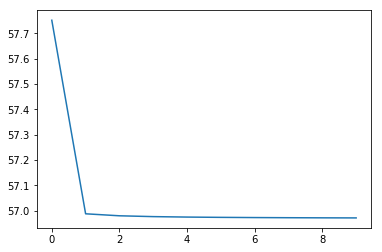

In [172]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
model.to(device)

lr, epochs, batch_size = 1e-1 , 10 , 2
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
train_accum=[]
i = 0
for k in range(epochs):
    localaccum = []
    for xy, conn in iter(loader):
        i =  i+1
        local_xy = Variable(xy)
        local_xy = local_xy.to(device)
        
        local_conn = Variable(conn)
        local_conn = local_conn.to(device)
        
        output = model.forward(local_xy,local_conn)
        output = output.to(device)
        
        #print(output)
        output = torch.norm(output)
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        print("network loss -> ", loss)
        #print(local_xy, local_xyz)
        #if (i%500 == 0): print("network loss -> ", loss)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.item())
    train_accum.append(np.mean(localaccum))
plt.plot(train_accum);                      

In [175]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
model.to(device)
msda = []
l2_norm = []
n = train_xy_obj.shape[0]
for i in range(n):
    print(i)
    obj = torch.Tensor(train_xy_obj[i].unsqueeze(0)).to(device)
    conn = torch.Tensor(train_xy_conn[i].unsqueeze(0)).to(device)
    output = model.forward(obj, conn)
    print("Gram matrix shape:", output.shape)
    print("Gram matrix:", output)
    msda.append(torch.norm(output))  
    if (i == 0):
        origin = output
        print(origin)
    else:    
        l2_norm.append(torch.norm(origin - output))
print(msda)        

cuda:0
0
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
1
Gram matrix s

Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
17
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
18
Gram 

Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
45
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  

Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
70
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
71
Gram 

Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
96
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  

Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
121
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
122
Gra

Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
147
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 

174
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
175
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.00

Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
202
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
203
Gra

Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
230
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
231
Gra

Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
258
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 

Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
283
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
284
Gra

Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
309
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 

Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
335
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 

Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
360
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
361
Gra

Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
386
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 

Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
414
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 

Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
442
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 

Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
470
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 

Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
498
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 

Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
526
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 

Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
553
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
554
Gra

Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
581
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 

Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
608
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 

Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
635
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
636
Gra

Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
662
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
663
Gra

Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
689
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
690
Gra

Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
717
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 

744
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
745
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.00

Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
772
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 

Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
800
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 

Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
827
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
828
Gra

Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
854
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
855
Gra

Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
882
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
883
Gra

Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
910
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
911
Gra

Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
938
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 

Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
965
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
966
Gra

Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
993
Gram matrix shape: torch.Size([1, 190, 190])
Gram matrix: tensor([[[ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, 

In [176]:
import plotly.graph_objs as go

obj = objs[1]

x = obj[0]
y = obj[1]
z = obj[2]

print(x,y,z)

# trace = go.Mesh3d(x=x,y=y,z=z,color='#0066FF',opacity=0.80)
# py.iplot([trace])

trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgb(204, 204, 204)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

[ 0.55752116  0.55356139  0.53791565  0.58974606 -0.53618759 -0.55960864] [ 0.38592494 -0.39448494  0.39631835 -0.38611883 -0.41011173 -0.38963553] [-0.25861984 -0.28268448  0.24841641  0.27617627 -0.26754078  0.26262727]


In [32]:
import plotly.graph_objs as go

obj = objs[0]

x = obj[0]
y = obj[1]
z = obj[2]

print(x,y,z)


trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgb(204, 204, 204)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

[-1. -1. -1.  1.  1.  1.  1.] [-0.99999636  0.99999636 -1.00000358  1.00000358 -0.99999636  0.99999636
 -1.00000358] [-1.00000358  1.00000358  0.99999636 -0.99999636 -1.00000358  1.00000358
  0.99999636]


Training #1

In [181]:
train_xy_obj = [] #torch.Tensor()
train_xy_conn = []

with open('training/vverts/r_25_30/data.pickle', 'rb') as f:
    data = pickle.load(f)

for i in range(len(data)):
    if(i%2 > 0):
        continue
    obj = np.asarray(data[i])
    #print("obj: ", obj)
    #print("obj shape: ",obj.shape)
    
    vv = obj.shape[1]
    obj[2,0:vv]=np.random.rand(vv)
    vverts = torch.from_numpy(np.asarray(obj,dtype=np.float32))
    vverts = vverts.unsqueeze(0)
    pad = nverts - vv
    m = nn.ZeroPad2d((0, pad, 0, 0)) #padding(left,right,top,bottom)
    x = m(vverts)
    train_xy_obj.append(x)    
    
    conn = np.asarray(data[i+1]) 
    conn = torch.from_numpy(np.asarray(conn,dtype=np.float32))
    conn = conn.unsqueeze(0)
    #print("conn: ", conn)
    #print("conn shape: ",conn.shape)
    conn_mat = expand_conn_mat(nverts,vv,conn)
    #print("conn mat: ", conn_mat)    
    train_xy_conn.append(conn_mat)


train_xy_obj = torch.cat(train_xy_obj)
print(train_xy_obj.shape)

train_xy_conn = torch.cat(train_xy_conn)
print(train_xy_conn.shape)

AssertionError: input is too small

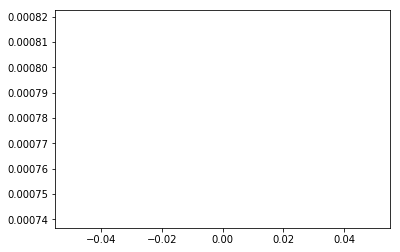

In [64]:
plt.plot(train_accum[0:5]);

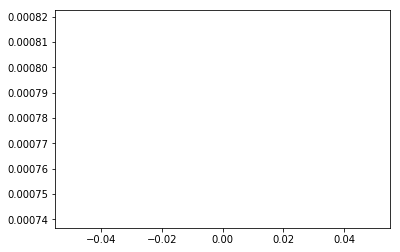

In [65]:
plt.plot(train_accum[0:5]);

In [503]:
train_accum

[0.0009727848519105464]

In [143]:
# Block Object
test_xy_Block_obj = []
test_xy_Block_conn = []
objs = []

with open('test/Block4/Obj1/data.pickle', 'rb') as f:
    data = pickle.load(f)

for i in range(len(data)):
    if(i%2 > 0):
        continue
    obj = np.asarray(data[i]) 
    #print(obj)
    vv = obj.shape[1]
    print("vverts:",vv)
    objs.append(np.copy(obj))
    
    obj[2,0:vv]= np.random.rand(vv)
    #print(obj)
    vverts = torch.from_numpy(np.asarray(obj,dtype=np.float32))
    vverts = vverts.unsqueeze(0)
    pad = nverts - vv
    m = nn.ZeroPad2d((0, pad, 0, 0))
    x = m(vverts)
    test_xy_Block_obj.append(x)    

    conn = np.asanyarray(data[i+1])    
    #print(conn)
    conn = torch.from_numpy(np.asarray(conn,dtype=np.float32))
    conn = conn.unsqueeze(0)
    conn_mat = expand_conn_mat(nverts,vv,conn)
    test_xy_Block_conn.append(conn_mat)

    
test_xy_Block_obj = torch.cat(test_xy_Block_obj)
test_xy_Block_conn = torch.cat(test_xy_Block_conn)

vverts: 8
vverts: 8
vverts: 10
vverts: 10
vverts: 8
vverts: 11
vverts: 11
vverts: 7
vverts: 8
vverts: 5


In [144]:
from numpy import linalg as LA
msda = []
l2_norm = []
n = test_xy_Block_obj.shape[0]
for i in range(n):
    print(i)
    obj = torch.Tensor(test_xy_Block_obj[i].unsqueeze(0)).to(device)
    conn = torch.Tensor(test_xy_Block_conn[i].unsqueeze(0)).to(device)
    output = model.forward(obj, conn)
    msda.append(torch.norm(output))  
    if (i == 0):
        origin = output
        print(origin)
    else:    
        l2_norm.append(torch.norm(origin - output))


l2_norm = torch.stack(l2_norm,dim=0)
print("l2 norm diffs:", l2_norm)
print("l2 norm diffs mean:", torch.mean(l2_norm))
print("l2 norm std:", torch.std(l2_norm))

msda = torch.stack(msda,dim=0)
print("msda: ", msda)
print("msda mean: ", torch.mean(msda))
print("msda std:", torch.std(msda))

0
tensor([[[ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]], device='cuda:0')
1
2
3
4
5
6
7
8
9
l2 norm diffs: tensor([ 0.1994,  5.0105,  4.9992,  5.8444,  6.5966,  6.5030,  4.4598,
         6.2277,  4.5747], device='cuda:0')
l2 norm diffs mean: tensor(4.9350, device='cuda:0')
l2 norm std: tensor(1.9528, device='cuda:0')
msda:  tensor([ 4.3506,  4.3653,  4.8129,  4.8667,  4.1508,  5.6953,  5.5866,
         2.2372,  5.2636,  2.0000], device='cuda:0')
msda mean:  tensor(4.3329, device='cuda:0')
msda std: tensor(1.2771, device='cuda:0')


In [271]:
model.forward(torch.Tensor(test_xy_Block_obj[1].unsqueeze(0)).to(device), 
              torch.Tensor(test_xy_Block_conn[1].unsqueeze(0)).to(device), extract_z=True)

z output vec: tensor([[ 0.1736, -0.0000,  0.9531, -0.0000, -0.4016,  0.0000,  0.2232,
          0.2181,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000,
          0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000, -0.0000,  0.0000, -0.0000,  0.1228,
          0.7469,  0.0000,  0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
          0.5062, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, -0.1679, -0.0000,  0.9560,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.00

tensor([[ 0.0016, -0.0117,  0.1295, -0.0547, -0.0176,  0.0577,  0.0056,
         -0.0014, -0.0989,  0.0202, -0.0100,  0.0093, -0.0107, -0.0083,
          0.0068,  0.0101, -0.0095,  0.0151,  0.0021, -0.0012]], device='cuda:0')

In [251]:
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

x = obj[0]

y = obj[1]

z = obj[2]

#x=[(i-min(x))/(max(x)-min(x)) for i in x]

#y=[(i-min(y))/(max(y)-min(y)) for i in y]

#z=[(i-min(z))/(max(z)-min(z)) for i in z]

#verts = [list(zip(x, y,z))]
#x,y,z=zip(*verts)

trace = go.Mesh3d(x=x,y=y,z=z,color='#0066FF',opacity=0.50)
py.iplot([trace])

In [256]:
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

x = obj[0]

y = obj[1]

z =  [ 0.0021,  0.0070,  0.0029, -0.0040, -0.0219,  0.0576, -0.0570,
          0.0657, -0.1073 ]

#x=[(i-min(x))/(max(x)-min(x)) for i in x]

#y=[(i-min(y))/(max(y)-min(y)) for i in y]

#z=[(i-min(z))/(max(z)-min(z)) for i in z]

#verts = [list(zip(x, y,z))]
#x,y,z=zip(*verts)

trace = go.Mesh3d(x=x,y=y,z=z,color='#0066FF',opacity=0.50)
py.iplot([trace])

TEST BY RENDERING

In [102]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
    
def test_reconstruct(N):
    print(N)
    print("******************************")
    fig = plt.figure()
    ax = Axes3D(fig)

    test_obj=test_xyz[N,:,:]
    d,t = test_obj.size()
    obj,conn = torch.Tensor.split(test_obj,[8,t-8],dim=1)
    #print(obj)
    #print(conn)
    fullobj = np.concatenate((obj,conn), axis=1)
    computed_z = model.forward(torch.Tensor([fullobj]).to(device), extract_z=True)
    orig_z = obj[2]


    print("_________ORIG________")

    x=obj[0]
    y=obj[1]
    z=obj[2]


    x=[(i-min(x))/(max(x)-min(x)) for i in x]
    y=[(i-min(y))/(max(y)-min(y)) for i in y]
    z=[(i-min(z))/(max(z)-min(z)) for i in z]

    verts = [list(zip(x, y,z))]
    #ax.add_collection3d(Poly3DCollection(verts))
    ax.scatter(x, y, z, c='r', marker='o')
    plt.show()


    print("_________RECON________")

    fig = plt.figure()
    ax = Axes3D(fig)
    x=obj[0]
    y=obj[1]
    z=computed_z.to('cpu').detach().numpy()[0]
    #print("Test  obj's   z: ", obj[2])
    #print("Model computed z:", z)

    x=[(i-min(x))/(max(x)-min(x)) for i in x]
    y=[(i-min(y))/(max(y)-min(y)) for i in y]
    z=[(i-min(z))/(max(z)-min(z)) for i in z]

    verts = [list(zip(x, y,z))]
    #ax.add_collection3d(Poly3DCollection(verts))
    ax.scatter(x, y, z, c='r', marker='o')
    plt.show()



In [103]:
N=[15,]

50
******************************
z output vec: tensor([[-1.0672, -0.9106, -2.5564, -0.0000, -1.0795, -0.9229, -2.5688,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  1.9512,
          0.0000,  0.0000, -0.0000,  2.3076, -0.0005,  0.0007,  0.0023,
          0.0009,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


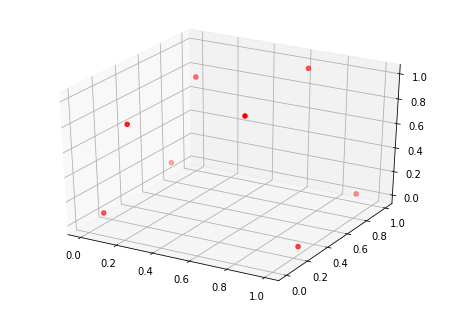

_________RECON________


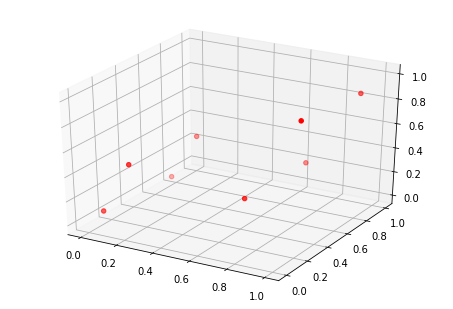

51
******************************
z output vec: tensor([[-0.8605, -1.3156, -2.5164, -0.0000, -0.8729, -1.3280, -2.5287,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  1.5594,
          0.0000, -0.0000,  0.0000,  1.9158, -0.0004,  0.0012,  0.0027,
          0.0009,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


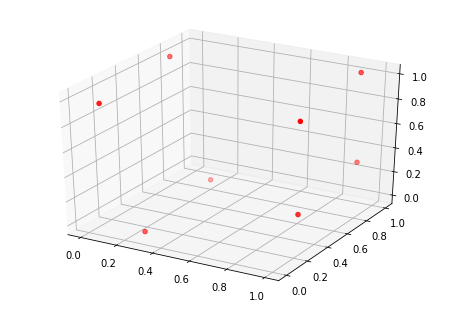

_________RECON________


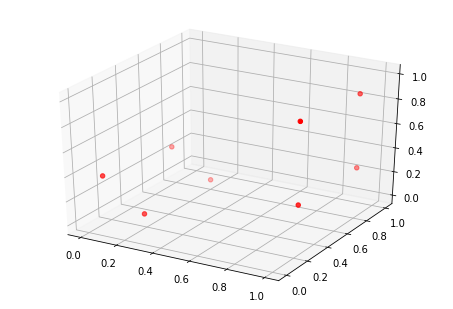

52
******************************
z output vec: tensor([[-1.4830, -0.8673, -2.5564, -0.0000, -1.4954, -0.8796, -2.5688,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  1.6242,
          0.0000,  0.0000, -0.0000,  1.9806, -0.0005, -0.0001,  0.0023,
          0.0009, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


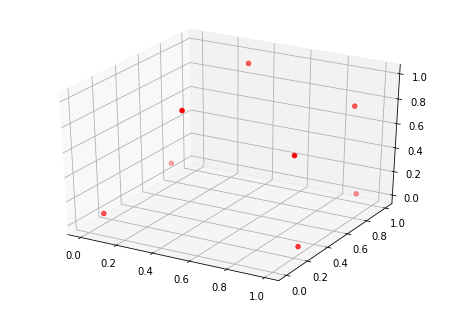

_________RECON________


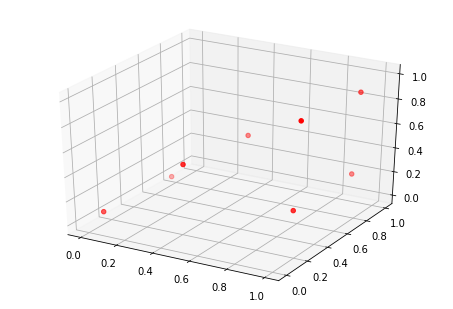

53
******************************
z output vec: tensor([[-0.8074, -1.3263, -2.5164, -0.0000, -0.8198, -1.3387, -2.5287,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  2.0766,
          0.0000, -0.0000,  0.0000,  2.4329, -0.0003,  0.0020,  0.0027,
          0.0009,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


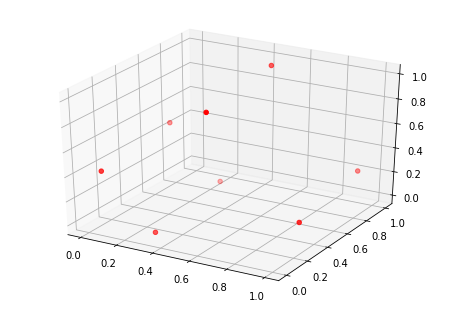

_________RECON________


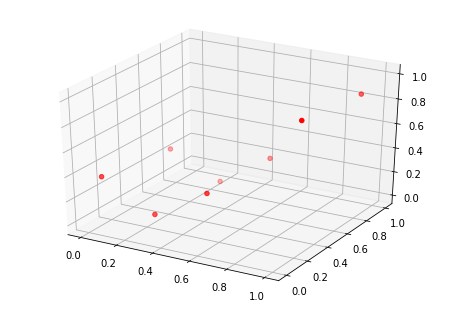

54
******************************
z output vec: tensor([[-1.0864, -1.4373, -2.5024, -0.0000, -1.0988, -1.4497, -2.5147,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  1.7854,
          0.0000, -0.0000,  0.0000,  2.1418, -0.0006,  0.0006,  0.0026,
          0.0009,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


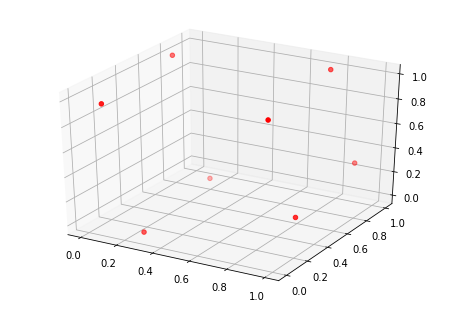

_________RECON________


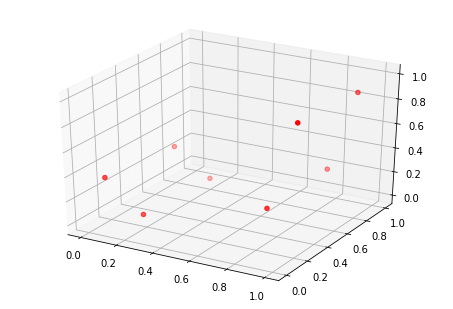

55
******************************
z output vec: tensor([[-1.2926, -0.8458, -2.5612, -0.0000, -1.3049, -0.8582, -2.5736,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  1.6991,
          0.0000,  0.0000, -0.0000,  2.0555, -0.0005,  0.0002,  0.0021,
          0.0009, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


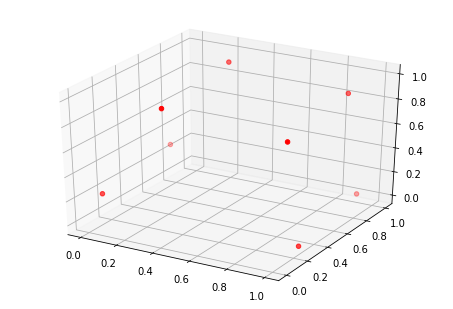

_________RECON________


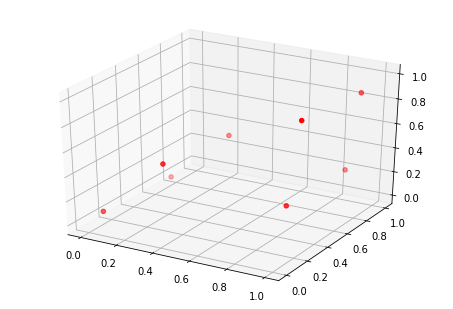

56
******************************
z output vec: tensor([[-1.0672, -0.9106, -2.5564, -0.0000, -1.0795, -0.9229, -2.5688,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  1.9512,
          0.0000,  0.0000, -0.0000,  2.3076, -0.0005,  0.0007,  0.0023,
          0.0009,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


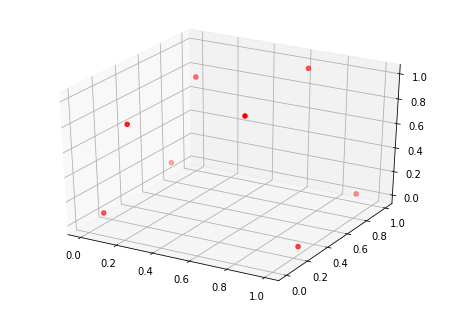

_________RECON________


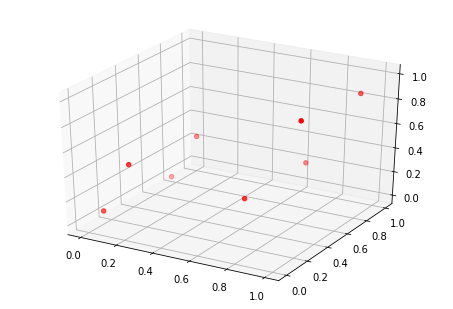

57
******************************
z output vec: tensor([[-0.9374, -1.3156, -2.5164, -0.0000, -0.9497, -1.3280, -2.5287,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  2.0766,
          0.0000, -0.0000,  0.0000,  2.4329, -0.0003,  0.0012,  0.0027,
          0.0009,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


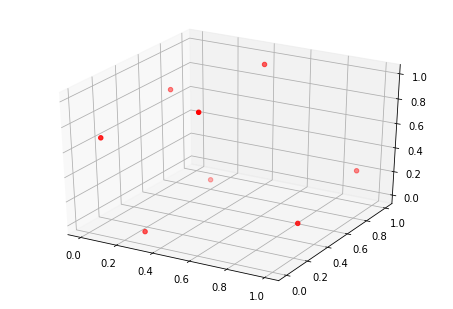

_________RECON________


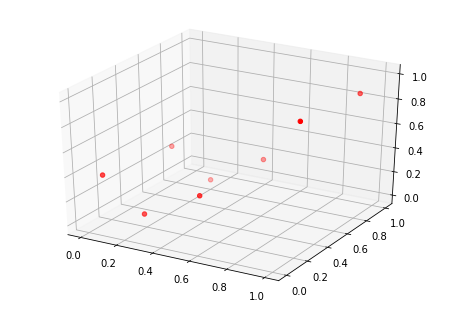

58
******************************
z output vec: tensor([[-0.8605, -1.7628, -2.4723, -0.0000, -0.8729, -1.7752, -2.4847,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  1.5594,
          0.0000, -0.0000,  0.0000,  1.9158, -0.0004,  0.0012,  0.0024,
          0.0009,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


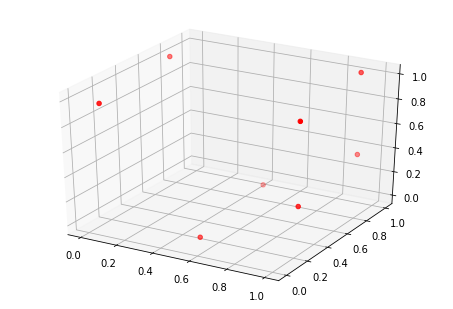

_________RECON________


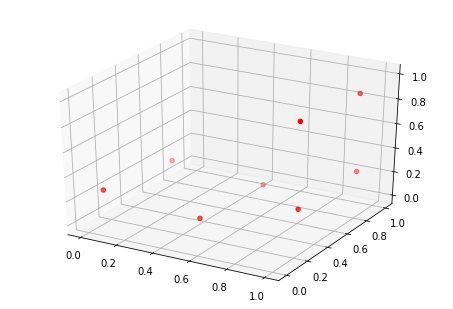

59
******************************
z output vec: tensor([[-1.0672, -0.9106, -2.5564, -0.0000, -1.0795, -0.9229, -2.5688,
          0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  1.9512,
          0.0000,  0.0000, -0.0000,  2.3076, -0.0005,  0.0007,  0.0023,
          0.0009,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
_________ORIG________


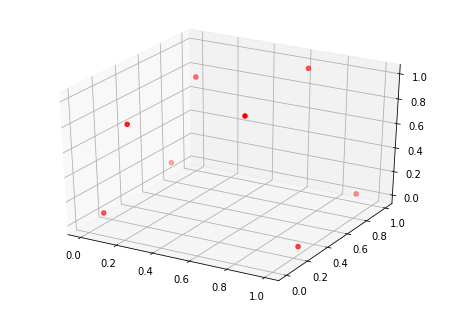

_________RECON________


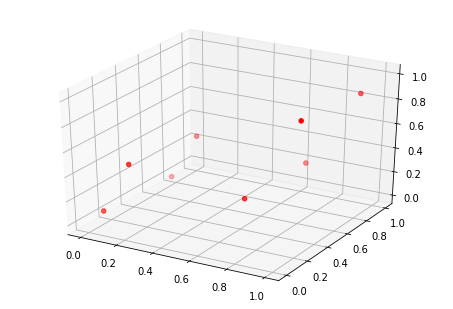

In [105]:
for i in range(50,60):
    test_reconstruct(i)

In [11]:
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

x = [-0.62336195, -0.68765551, -0.60835618, -0.73098087,  0.68765551,
         0.60835618,  0.73098087,  0.        ,  0.        ,  0.  ]

y =  [-0.72208285, -0.84163195,  0.61289209,  0.71019131, -0.84163195,
         0.61289209,  0.71019131,  0.6544894 ,  0.71622545, -0.79593921 ]

z =  [-0.67852008,  0.74539661, -0.76140082,  0.64347017,  0.74539661,
        -0.76140082,  0.64347017, -0.81237978,  0.65151095,  0.76727116]

#x=[(i-min(x))/(max(x)-min(x)) for i in x]

#y=[(i-min(y))/(max(y)-min(y)) for i in y]

#z=[(i-min(z))/(max(z)-min(z)) for i in z]

#verts = [list(zip(x, y,z))]
#x,y,z=zip(*verts)

trace = go.Mesh3d(x=x,y=y,z=z,color='#FFB6C1',opacity=0.50)
py.iplot([trace])

Test Performance

In [16]:
import torch.utils.data
dataset = torch.utils.data.TensorDataset(test_xy[:,:,:], test_xyz[:,:,:])
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

cuda:0


/home/mishra/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


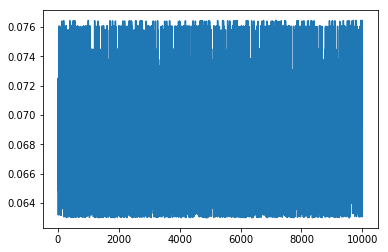

In [129]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
model.to(device)
criterion = nn.L1Loss()
lr, epochs, batch_size = 1e-1 , 1 , 1
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
i = 0
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        i =  i+1
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        local_xyz = local_xyz.to(device)
        output = model.forward(local_xy)
        output = output.to(device)
        #print("output:",output)
        #print("actual:", local_xyz[:,2,0:8])
        #loss = criterion(output, local_xyz[:,2,0:8])
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        
        #print(local_xy, local_xyz)
        #if (i%100 == 0): print("network loss -> ", loss)
        #model.zero_grad()
        #loss.backward()
        #optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(localaccum);                                           

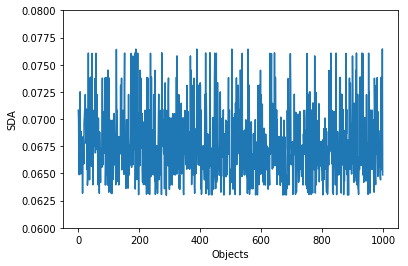

In [139]:
plt.ylabel('SDA')
plt.xlabel('Objects')
plt.ylim((0.06,0.08))
plt.plot(localaccum[0:1000])